In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time


@torch.jit.script
def parallel_metropolis_update(state: torch.Tensor, W: torch.Tensor, temperature: float, steps: int):
    """Parallel Metropolis update.
    - ΔE = 2 * s_i * h_i  (energy *increase* when spin i is flipped)
    - Always flip if ΔE ≤ 0 (energy‑lowering)
    - Otherwise flip with exp(‑ΔE / T)  (ΔE > 0)
    """
    for _ in range(steps):
        h = torch.matmul(W, state)                     # local fields
        delta_E =  2.0 * state * h                     # *** correct sign ***

        # deterministic flips that LOWER the energy
        flip_mask = delta_E <= 0

        # stochastic flips that RAISE the energy
        rand_vals = torch.rand(state.size(0), device=state.device)
        prob = torch.exp(-delta_E / temperature)       # valid only where ΔE > 0
        flip_mask |= (rand_vals < prob) & (delta_E > 0)

        state = state.clone()
        state[flip_mask] *= -1
    return state
@torch.jit.script
def parallel_metropolis_update_batch(
        state: torch.Tensor,      # (B, N)
        W:     torch.Tensor,      # (B, N, N)
        T:     float,
        steps: int):
    """
    Batched version: B independent Hopfield systems in parallel.
    """
    B, N = state.shape
    for _ in range(steps):
        h = torch.bmm(W, state.unsqueeze(-1)).squeeze(-1)      # W : (B, N, N ), state: (B,N)
        dE = 2.0 * state * h                                   # (B, N)

        # deterministic flips
        flip = dE <= 0

        # stochastic flips
        r    = torch.rand_like(state)
        flip |= (r < torch.exp(-dE / T)) & (dE > 0)

        state = state.clone()
        state[flip] *= -1
    return state

class HopfieldNetwork:
    def __init__(self, N: int, temperature: float = 1.0, device: str | None = None):
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.N           = N
        self.temperature = temperature
        self.memories    = []          # list[Tensor]
        self.M           = 0
        # *** weights are initialised to zero and will be ⟨ξ ξᵀ⟩/N ***
        self.W = torch.zeros((N, N), dtype=torch.float32, device=self.device)

    # ------------------------------------------------------------------
    #  memory management
    # ------------------------------------------------------------------
    def add_memory(self, memory: torch.Tensor):
        """Store a pattern and update weights with Hebb rule normalised by 1/N."""
        memory = memory.to(self.device)
        assert memory.shape == (self.N,)
        assert torch.all((memory == 1) | (memory == -1)), "Memory must be ±1"
        self.memories.append(memory)
        self.M = len(self.memories)
        #self.W += torch.ger(memory, memory) / self.N
        #self.W.fill_diagonal_(0)
        self.learn_memories()

    def store_random_memories(self, M: int):
        rand_mem = (torch.randint(0, 2, (self.N,M), device=self.device) * 2 - 1).float()
        for m in range(M):
            self.memories.append(rand_mem[:,m])
        self.M = len(self.memories)
        self.learn_memories()

    def learn_memories(self):
        mem_matrix = torch.stack(self.memories)
        self.W = (mem_matrix.t() @ mem_matrix) / self.N
        self.W.fill_diagonal_(0)

    def store_checkerboard_memory(self):
        pattern = torch.tensor([(1 if i % 2 == 0 else -1) for i in range(self.N)], dtype=torch.float32, device=self.device)
        self.add_memory(pattern)

    # ------------------------------------------------------------------
    #  dynamics
    # ------------------------------------------------------------------
    def retrieve(self, initial_state: torch.Tensor, steps: int = 10):
        state = initial_state.clone().float().to(self.device)
        return parallel_metropolis_update(state, self.W, self.temperature, steps)

    # ------------------------------------------------------------------
    #  analysis helpers
    # ------------------------------------------------------------------
    def compute_overlaps(self, state: torch.Tensor):
        mem_matrix = torch.stack(self.memories)                   # (M, N)
        overlaps   = ((mem_matrix @ state) / self.N).abs()             # sign‑invariant
        return overlaps

    def get_alpha(self):
        return self.M / self.N

    # ------------------------------------------------------------------
    #  phase‑diagram routine (unchanged except for more steps default)
    # ------------------------------------------------------------------
    def _single_point(self, alpha: float, T: float, steps:int,runs_per_setting:int,noise:float) -> float:
        M = int(alpha * self.N)

        # -- 1. random memories for *all* runs at once --
        memories = (torch.randint(0, 2, (runs_per_setting, M, self.N), device=self.device)
                    * 2 - 1).float()                     # (B, M, N) with B=runs

        # -- 2. Hebbian weights: W_b = ξ_bᵀ ξ_b / N --
        W = torch.bmm(memories.transpose(1, 2), memories).div_(self.N)  # (B, N, N)
        W -= torch.diag_embed(torch.diagonal(W, dim1=1, dim2=2))   # zero diag

        # -- 3. choose a true pattern for every run --
        idx = torch.randint(0, M, (runs_per_setting,), device=self.device)
        true_mem = memories[torch.arange(runs_per_setting, device=device), idx]  # (B, N)

        # -- 4. add noise (flip 'noise' fraction of bits) --
        noisy = true_mem.clone()
        flip  = torch.rand_like(noisy) < noise
        noisy[flip] *= -1

        # -- 5. asynchronous dynamics, batched --
        final_state = parallel_metropolis_update_batch(noisy, W, T, steps)  # (B, N)

        # -- 6. overlaps: |ξ·s|/N for all patterns & runs --
        # overlaps_bm = (memories_bmn @ s_bn) / N
        overlaps = torch.bmm(memories, final_state.unsqueeze(-1)).squeeze(-1).abs_().div_(N)  # (B, M)

        return overlaps.max(1).values.mean().item()

    def phase_diagram(self, alphas, temperatures,
                  steps=100, runs_per_setting=20, noise=0.50):
      """
      Fully batched over 'runs_per_setting' (inner loop).
      Returned array shape: (len(alphas), len(temperatures))
      """
      device  = self.device
      N       = self.N
      results = torch.zeros((len(alphas), len(temperatures)), device=device)
      for i, alpha in enumerate(alphas):
          for j, T in enumerate(temperatures):
            t0 = time.time()
            avg_m = self._single_point(alpha, T,steps, runs_per_setting,noise )
            dt = (time.time() - t0) / runs_per_setting
            results[i, j] = avg_m
            print(f"α={alpha:5.3f}  T={T:4.2f}  ⟨|m|⟩={avg_m:5.3f}   "
                  f"(≈{dt*1e3:4.1f} ms / run)")

      return results.cpu().numpy()

        # plotting
def plot_phase_diagram( alphas, temperatures, results):
  plt.figure(figsize=(8, 6))
  plt.imshow(results.T, origin="lower", aspect="auto",
              extent=( alphas[0], alphas[-1], temperatures[0], temperatures[-1]),
              cmap="viridis", vmin=0., vmax=1.)
  plt.colorbar(label="Average |overlap|")
  plt.ylabel("Temperature T")
  plt.xlabel(r"α = M / N")
  plt.title("Hopfield phase diagram (Metropolis (sync.))")
  plt.show()


# ----------------------------------------------------------------------
#  quick test
# ----------------------------------------------------------------------
if __name__ == "__main__":
    N = 5000
    M = 10
    T = 0.5     # intentionally > T_c
    print(f"N={N}, M={M}, T={T}, alpha={M/N}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Testing on", device)
    net = HopfieldNetwork(N, T, device)
    net.store_random_memories(M)
    true_memory = net.memories[3]

    # 10 % noise
    noisy = true_memory.clone()
    noisy[torch.rand(N, device=device) < 0.5] *= -1
    retrieved = net.retrieve(noisy, steps=100)
    print("overlap (50 % noise):", (retrieved @ true_memory).abs().item() / N)

    # 90 % noise
    noisy2 = true_memory.clone()
    noisy2[torch.rand(N, device=device) < 0.80] *= -1
    retrieved2 = net.retrieve(noisy2, steps=100)
    print("overlap (20 % noise):", (retrieved2 @ true_memory).abs().item() / N)

    # Uncomment to run phase diagram
    alphas = np.linspace(0.01, 0.20, 12)
    temperatures = np.linspace(0.01, 1.5, 10)
    results = net.phase_diagram(alphas, temperatures,steps=200,runs_per_setting=50,noise=0.2)


N=5000, M=10, T=0.5, alpha=0.002
Testing on cuda
overlap (50 % noise): 0.0116
overlap (20 % noise): 0.962
α=0.010  T=0.01  ⟨|m|⟩=1.000   (≈82.3 ms / run)
α=0.010  T=0.18  ⟨|m|⟩=1.000   (≈96.1 ms / run)
α=0.010  T=0.34  ⟨|m|⟩=0.993   (≈81.3 ms / run)
α=0.010  T=0.51  ⟨|m|⟩=0.950   (≈81.6 ms / run)
α=0.010  T=0.67  ⟨|m|⟩=0.836   (≈81.2 ms / run)
α=0.010  T=0.84  ⟨|m|⟩=0.242   (≈81.5 ms / run)
α=0.010  T=1.00  ⟨|m|⟩=0.155   (≈81.6 ms / run)
α=0.010  T=1.17  ⟨|m|⟩=0.001   (≈81.3 ms / run)
α=0.010  T=1.33  ⟨|m|⟩=0.001   (≈81.2 ms / run)
α=0.010  T=1.50  ⟨|m|⟩=0.001   (≈81.4 ms / run)
α=0.027  T=0.01  ⟨|m|⟩=1.000   (≈82.3 ms / run)
α=0.027  T=0.18  ⟨|m|⟩=1.000   (≈82.5 ms / run)
α=0.027  T=0.34  ⟨|m|⟩=0.990   (≈82.6 ms / run)
α=0.027  T=0.51  ⟨|m|⟩=0.937   (≈82.4 ms / run)
α=0.027  T=0.67  ⟨|m|⟩=0.527   (≈82.3 ms / run)
α=0.027  T=0.84  ⟨|m|⟩=0.169   (≈129.0 ms / run)
α=0.027  T=1.00  ⟨|m|⟩=0.140   (≈106.8 ms / run)
α=0.027  T=1.17  ⟨|m|⟩=0.075   (≈131.9 ms / run)
α=0.027  T=1.33  ⟨|m|⟩=0.00

In [ ]:
torch.rand((2,10)).max(1)[0].mean()

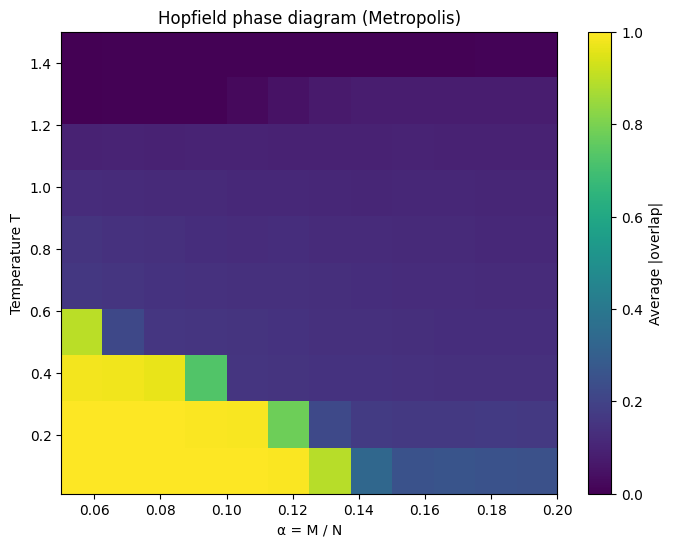

In [ ]:

plot_phase_diagram( alphas, temperatures, results)